
# Pipeline de Machine Larning - Model

## Authors

- Felipe Kenji Chikuji
- Kattson Bastos Santos

**Some Notes:**

- We didn't run a lot of models because there's no much difference between their performance in this data.
- The performance using only text columns was better than using a mix of text and the other variables. So, we decided to model the data only with the text columns, although using the others would be interesting in the construction of the pipeline in production (since we would have to add scaling, more missing values filtering, etc.)

# 0. Importing

In [1]:
import os
import nltk
import pickle 

import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus                        import stopwords


from sklearn.svm                        import SVC
from sklearn.metrics                    import confusion_matrix, classification_report
from sklearn.pipeline                   import Pipeline
from sklearn.ensemble                   import RandomForestClassifier
from sklearn.preprocessing              import LabelBinarizer, StandardScaler
from sklearn.model_selection            import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text    import CountVectorizer, TfidfTransformer


## 0.1. Helper Functions

In order to let the code be a little bit more clean and understandable, we decided to keep in the following cell some functions which will help us along the notebook.

In [2]:
def create_text_feature(data, stop_words_list):
    """
    Receives dataframe, concatenate its text columns, and remove stopwords.
    
    :param data: a Pandas Dataframe.
    :param stop_words_list: a list of stop words.
    
    :returns: a Pandas Series containing the concatenated string"""
    
    data = data.apply(lambda x: x['title'] + " " + x['query'] + " " + x['concatenated_tags'], axis =1)
    
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    
    return data



def create_fit_pipeline(X_data, y_data, model):
    """
    Creates and fits a pipeline for a received set of features and target.
    
    :param X: a pandas Dataframe of features.
    :param y: a a Pandas Series.
    :param model: a scikit-learn instanciated model.
    
    :returns: a fitted pipeline """
    
    pipeline = Pipeline([
        ("counter", CountVectorizer()),

        ("tfidf", TfidfTransformer()),

        ("clf", model)

      ])

    pipeline.fit(X_data, y_data)
    

    return pipeline


def load_pickle(file_pkl):
    """
    Receives a path of a pickle file and loads it.
    
    :param file_pkl: str referencing a .pkl file.
    
    :returns: the loaded object"""
    
    with open(file_pkl,'rb') as open_file:

        obj = pickle.load(open_file)
        
    return obj


def save_pickle(obj, path_name):
    """
    Receives and object and saves it in the received path.
    
    :param obj: any pickle serializable object.
    :param path_name: str referencing the path where the object is going to be saved.
    
    """
    
    with open(path_name, 'wb') as file:
        
        pickle.dump(obj, file)
        
        
def plot_cm(y_true, y_hat, labels):
    """
    Receives true and predicted data and plots a Confusion Matrix for them.
    
    :param y_true: Numpy Array of true labels.
    :param y_hat: Numpy Array of predicted labels.
    :param labels: label list to be used in the plot axis ticks.
    
    """
    
    cm = confusion_matrix(y_true, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1) 

    ax = sns.heatmap(
                  cm, 
                  annot=True, 
                  fmt=".2f", 
                  cmap='Blues',
                  ax=ax
              )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_title('Confusion Matrix')

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 

    plt.yticks(rotation=0)

    plt.ylim(b, t)

    plt.show()
    
    

## 0.2. Initializing some important variables

In [3]:
# path variables
DATASET_PATH  = os.environ['DATASET_PATH']
TEST_PATH     = os.environ['TEST_PATH']
MODEL_PATH    = os.environ['MODEL_PATH']
METRICS_PATH  = os.environ['METRICS_PATH']

# downloading and creating a portuguese list fo stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedipadawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Extraction

In [4]:
raw_data = pd.read_csv(DATASET_PATH)

test_data = pd.read_csv(TEST_PATH)

# 2. Data Formatting

Let's copy the dataframe to make it easier to re-run the code without having to load the data again.

In [5]:
df = raw_data

In [6]:
X = df.drop('category', axis =1)[['title', 'query', 'concatenated_tags']]

y = df['category']

## 2.1. Filling Missing Values

Since we're just going to use text columns as features, we'll fill missing values only for them.

In [7]:
X.isna().sum()

title                0
query                0
concatenated_tags    2
dtype: int64

Even though there's no missing values in `title` and `query` columns (as shown in the output above), we'll keep filling them with an empty string for future deploy purposes.

In [8]:
X['concatenated_tags'] = X.concatenated_tags.fillna('')

X['title'] = X.concatenated_tags.fillna('')

X['query'] = X.concatenated_tags.fillna('')

## 2.2. Using text Columns to create the feature

In [9]:
X = create_text_feature(X, stop_words)

## 2.3. Running the entire data preparation for the test dataset

In [10]:
X_test = test_data.drop('category', axis =1)[['title', 'query', 'concatenated_tags']]

y_test = test_data['category']

In [11]:
X_test['concatenated_tags'] = X_test.concatenated_tags.fillna('')

X_test['title'] = X_test.concatenated_tags.fillna('')

X_test['query'] = X_test.concatenated_tags.fillna('')

In [12]:
X_test = create_text_feature(X_test, stop_words)

In [13]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies_y_test = np.asarray((unique, counts)).T

print("-- Y test unique values count --")
print(frequencies_y_test, '\n')

-- Y test unique values count --
[['Bebê' 95]
 ['Bijuterias e Jóias' 11]
 ['Decoração' 122]
 ['Lembrancinhas' 230]
 ['Outros' 15]
 ['Papel e Cia' 27]] 



# 3. Modelling

Based on previous experiments, the use of different models gave us similar results.

So, in order to gain some time, we'll fit only a Support Vector Machine Classifier, since it showed a slightly better result.

However, in a real scenario, we would have to better chose the model to fit our data.

Since we need to find the best parameters, we'll perform a simple parameters tuning.
Again, in a real scenario, we should better perform this task.

The 'parameters tuning' usually goes after chosing the model and evaluating on the validation data. However, we decided to run it first because we already have a chosen model.

## 3.1. Finding Parameters

To save some time, we'll try to find the best parameters only for `C` and the `kernel`. That's because there's no much different in the model performance when changing other parameters.

_Note_: in order to let the notebook be more clean, we'll print all the metrics together at the end of this notebook.

**Results**:

- `C` = 10
- `kernel`= rbf

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [15]:
%%time

param_grid = {'C':[1,10], 'kernel':['linear','rbf']}

with open(METRICS_PATH, "a") as metrics_file:

    print(f"-- FINE TUNING RESULTS --", file=metrics_file)
    
for c in param_grid['C']:
    
    for k in param_grid['kernel']:
        
        print(f'Executing for params: c {c} and kernel {k}')
        
        svc_model = SVC(C=c, kernel=k, random_state=42)
        
        svc_pipeline = create_fit_pipeline(X_train, y_train, svc_model)
        
        svc_predictions = svc_pipeline.predict(X_valid)
        
        svc_report = classification_report(y_valid, svc_predictions)

        with open(METRICS_PATH, "a") as metrics_file:

            print(f"Support Vector Classifier - Fine Tuning for C {c} and kernel {k}", file=metrics_file)

            print(svc_report + '\n\n', file=metrics_file)


Executing for params: c 1 e kernel linear
Executing for params: c 1 e kernel rbf
Executing for params: c 10 e kernel linear
Executing for params: c 10 e kernel rbf
CPU times: user 7min 2s, sys: 1.06 s, total: 7min 3s
Wall time: 7min 4s


## 3.2. Fitting the best model

# 4. Model Validation

**About the metrics**

We choose to use a set of metrics in order to better approach our problem, since we have a different quantity of observations for each class.

- `accuracy`: basically, it is the number of correct predictions made by the model over all predictions made. Accuracy is usually used for balanced data, which is not our case. However, it's still usefull when combined with the following metrics.
- `recall`: the proportion of a specific class that was correctly predicted as being of that specific class.
- `precision`: proportion of a class that was predicted of being from that class that was actually from that class.
- `f1-score`: takes the harmonic mean between the precision and recall, reaching its best value at 1, and worst at 0. We decided to use it because it gives us a summary between recall and precision and we can better verify the performance of our model.
- `confusion matrix`: it helps us better look at the correctness and accuracy of the model. Also, we can plot it in a way that shows the recall of precision for each class.

Before evaluating the models, let's create a list containing the target labels to be used in the confusion matrix plot.

In [16]:
target_labels = df['category'].sort_values().unique()

## 4.1. Cross Validation Evaluation

To get a more robust model performance, we'll apply a stratified cross validations, since it allows us to see the metrics along different portions of the training dataset.

To gain some time, we'll divide it only in four splits.

In [17]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [18]:
fold = 1

with open(METRICS_PATH, "a") as metrics_file:
    
        print(f"CROSS VALIDATION RESULTS", file=metrics_file)

for train_index, test_index in skf.split(X, y):
    print(f'Starting fold {fold}')
    
    X_train = X.iloc[train_index,]
    y_train = y.iloc[train_index,]
    
    X_valid = X.iloc[test_index,]
    y_valid = y.iloc[test_index,]
    
       
    svc_model = SVC(C=10, kernel='rbf', random_state=42)
    
    model = create_fit_pipeline(X_train, y_train, svc_model)
    
    svc_predictions = model.predict(X_valid)
    
    svc_report = classification_report(y_valid, svc_predictions)
    
    with open(METRICS_PATH, "a") as metrics_file:
    
        print(f"Support Vector Classifier - Cross Validation Metrics for fold {fold}", file=metrics_file)

        print(svc_report + '\n\n', file=metrics_file)
    

    print(f"Support Vector Classifier - Cross Validation Metrics for fold {fold}")

    print(svc_report)
    
    fold += 1
    

Starting fold 1
Support Vector Classifier - Cross Validation Metrics for fold 1
                    precision    recall  f1-score   support

              Bebê       0.90      0.85      0.87      1732
Bijuterias e Jóias       0.95      0.91      0.93       235
         Decoração       0.89      0.87      0.88      2181
     Lembrancinhas       0.88      0.95      0.91      4381
            Outros       0.89      0.72      0.79       283
       Papel e Cia       0.83      0.68      0.75       688

          accuracy                           0.88      9500
         macro avg       0.89      0.83      0.86      9500
      weighted avg       0.88      0.88      0.88      9500

Starting fold 2
Support Vector Classifier - Cross Validation Metrics for fold 2
                    precision    recall  f1-score   support

              Bebê       0.88      0.86      0.87      1732
Bijuterias e Jóias       0.95      0.89      0.92       235
         Decoração       0.88      0.88      0.88      2

## 4.2. Evaluating On the Test Data

In [19]:
svc_model = SVC(C=10, kernel='rbf', random_state=42)

svc_pipeline = create_fit_pipeline(X, y, svc_model)

In [20]:
svc_predictions = svc_pipeline.predict(X_test)

In [21]:
svc_report = classification_report(y_test, svc_predictions)

with open(METRICS_PATH, "a") as metrics_file:
    
    print("Support Vector Classifier - Test Metrics", file=metrics_file)
    
    print(svc_report + '\n\n', file=metrics_file)

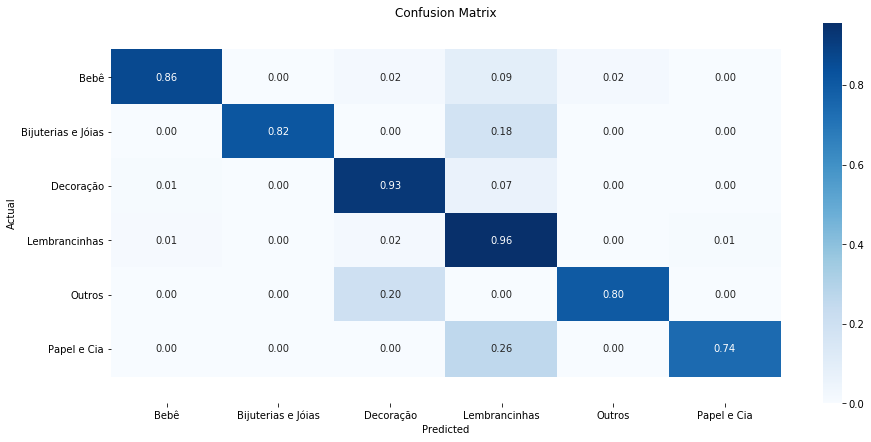

In [22]:
plot_cm(y_test.values, svc_predictions, target_labels)

# 5. Model exportation

In [23]:
save_pickle(svc_pipeline, MODEL_PATH)

# Printing the metrics

In [24]:
!cat {METRICS_PATH}

-- FINE TUNING RESULTS --
Support Vector Classifier - Fine Tuning for C 1 and kernel linear
                    precision    recall  f1-score   support

              Bebê       0.87      0.79      0.83      2079
Bijuterias e Jóias       0.93      0.86      0.90       282
         Decoração       0.87      0.84      0.86      2617
     Lembrancinhas       0.84      0.94      0.88      5257
            Outros       0.82      0.56      0.67       340
       Papel e Cia       0.83      0.58      0.68       825

          accuracy                           0.85     11400
         macro avg       0.86      0.76      0.80     11400
      weighted avg       0.85      0.85      0.85     11400



Support Vector Classifier - Fine Tuning for C 1 and kernel rbf
                    precision    recall  f1-score   support

              Bebê       0.91      0.82      0.86      2079
Bijuterias e Jóias       0.95      0.82      0.88       282
         Decoração       0.87      0.87      0.87      2617